In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bluebook-for-bulldozers/Valid.7z
/kaggle/input/bluebook-for-bulldozers/Valid.zip
/kaggle/input/bluebook-for-bulldozers/Train.zip
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv
/kaggle/input/bluebook-for-bulldozers/median_benchmark.csv
/kaggle/input/bluebook-for-bulldozers/Valid.csv
/kaggle/input/bluebook-for-bulldozers/Machine_Appendix.csv
/kaggle/input/bluebook-for-bulldozers/random_forest_benchmark_test.csv
/kaggle/input/bluebook-for-bulldozers/Data Dictionary.xlsx
/kaggle/input/bluebook-for-bulldozers/ValidSolution.csv
/kaggle/input/bluebook-for-bulldozers/Test.csv
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.zip
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.7z
/kaggle/input/bluebook-for-bulldozers/Train.7z


## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll use to tune HyperParameters).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

[Root Mean Squre vs Root Mean Squared Log Error](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

In [2]:
train_and_valid = pd.read_csv("../input/bluebook-for-bulldozers/TrainAndValid.csv",
                             low_memory = False, #to avoid the error shown above
                             parse_dates = ["saledate"]) #to convert into date time, (see column index - 9)
train_and_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [3]:
train_and_valid.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_and_valid.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## 5. Data Visualization

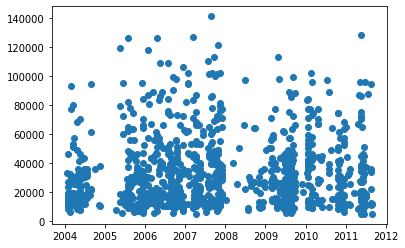

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(train_and_valid["saledate"][:1000], train_and_valid["SalePrice"][:1000]);

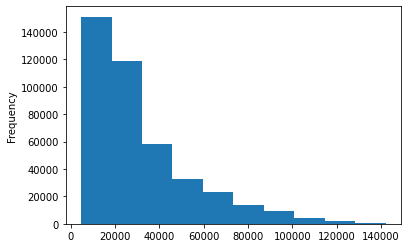

In [6]:
train_and_valid.SalePrice.plot.hist();

## 6. Process the data

This won't work since we've got missing numbers and categories
```python
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)
```
We still have data types which are not compatible for the model

---
### Add datetime parameters for saledate column

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

### Convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.

### Filling numerical values
We're going to fill any column with missing values with the median of that column.
After filling the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [7]:
# Import Pipeline from sklearn's pipeline module
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def preprocess_data(df):
    # Add datetime parameters for saledate
#     global saleYear, saleMonth, saleDay
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['saleDay'] = df['saledate'].dt.day

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
#     df.drop("SalesID", axis=1, inplace=True) # this doesn't follow a pattern
    
    
    # Fill numeric rows with the median
    for label, content in df.items():
        temp = label+"_is_missing"
        if pd.api.types.is_numeric_dtype(content):
#         if pd.isnull(content).sum():
            df[temp] = pd.isnull(content)
            df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

data_process = FunctionTransformer(preprocess_data, validate = False)

### Splitting data into train/valid sets

We need had to preprocess the data so we didn't took "train.csv" and "valid.csv" separately. We will split our processed data. The validation set and test set are split according to dates.  
This makes sense since we're working on a time series problem.    
E.g. using past events to try and predict future events.  

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.  
Instead, we split our data into training, validation and test sets using the date each sample occured.  
In our case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [8]:
# split the data into training and validation
df_valid = train_and_valid[train_and_valid['saledate'].dt.year == 2012] 
df_train = train_and_valid[train_and_valid['saledate'].dt.year != 2012]

df_valid.shape, df_train.shape

# split the data in X and y

X_train = df_train.drop("SalePrice", axis = 1)
y_train = df_train["SalePrice"]

X_valid = df_valid.drop("SalePrice", axis = 1)
y_valid = df_valid["SalePrice"]

## 7. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find a [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good candidate.

### Hyperparameter Tunning

Before training the model on full 400k records, we will train it on 10k records and find the best model by hyperparameter tunning. Once we are able to find the best sets of parameter, we will train the model with full dataset.

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators" : np.arange(10, 100, 10), 
          "max_depth": [None, 3, 5, 10],
          "min_samples_split" : np.arange(2, 20, 2),
          "min_samples_leaf" : np.arange(1, 20, 2),
          "max_features" : [0.5, 1, "sqrt", "auto"],
          "max_samples" : [10000]}

model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions = rf_grid,
                              n_iter = 20,
                              n_jobs = -1,
                              cv = 5, 
                              verbose = True)

### Creating the pipeline

In [10]:
model_pipeline = Pipeline(steps = [
    ("preprocess", data_process),
    ('model_rfr', model)
])

### Fitting the pipeline

In [11]:
model_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess_data at 0x7fd167a054d0>)),
                ('model_rfr',
                 RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                                    n_iter=20, n_jobs=-1,
                                    param_distributions={'max_depth': [None, 3,
                                                                       5, 10],
                                                         'max_features': [0.5,
                                                                          1,
                                                                          'sqrt',
                                                                          'auto'],
                                                         'max_samples': [10000],
                                                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                           

In [12]:
y_preds = model_pipeline.predict(X_valid)

### Building an evaluation function

It's important to understand the evaluation metric you're going for.  
**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own. We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).  
We'll also calculate the MAE and R^2 for our evaluation

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

#create a function to get other values
def show_scores(y_test, y_preds):
    scores = {"MAE" : mean_absolute_error(y_test, y_preds),
              "RMSLE" : rmsle(y_test, y_preds),
              "R^2" : r2_score(y_test, y_preds)} #default parameter 
    return scores

In [14]:
show_scores(y_valid, y_preds)

{'MAE': 10406.24334441175,
 'RMSLE': 0.4192526612720929,
 'R^2': 0.6171523941150406}

In [15]:
model_pipeline[1]

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

## 8. Creating test predictions

Although we are creating a submission file. The competiton is closed and we have to consider the valid scores as evaluation parameter only.

In [16]:
test = pd.read_csv("../input/bluebook-for-bulldozers/Test.csv",
                             low_memory = False, #to avoid the error shown above
                             parse_dates = ["saledate"]) #to convert into date time, (see column index - 9)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [17]:
y_preds_test = model_pipeline.predict(test)

In [18]:
test_submission = pd.DataFrame(data = [test["SalesID"].astype(int), 
                                y_preds_test], 
                        index = ["SalesID", "SalesPrice"])
test_submission = test_submission.T
test_submission.head()

,SalesID,SalesPrice
0,1227829.0,20169.921932
1,1227844.0,23489.665784
2,1227847.0,50464.845515
3,1227848.0,80836.230935
4,1227863.0,41957.288937


In [19]:
test_submission.to_csv("./predictions.csv", index=False)


### Feature Importance

In [20]:
feature_importance= pd.DataFrame(data = [model.best_estimator_.feature_importances_],
                                 columns = test.columns,
                                 index = ["features_importance"]).T.sort_values("features_importance",
                                               ascending = False)
    
feature_importance

,features_importance
YearMade,0.307574
ProductSize,0.280900
saleYear,0.058324
fiSecondaryDesc,0.057406
fiBaseModel,0.047716
...,...
Enclosure_is_missing,0.000000
Forks_is_missing,0.000000
Pad_Type_is_missing,0.000000
Turbocharged_is_missing,0.000000


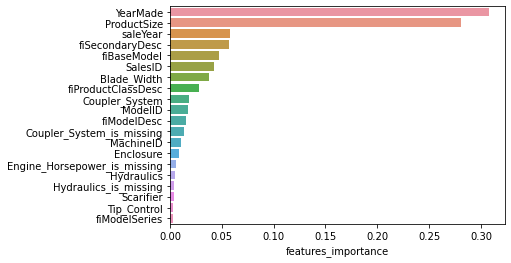

In [21]:
import seaborn as sns 

def plot_features(df, n = 20): # plot top 20 (be default) features
    
    sns.barplot(x = "features_importance",
                y = df.index[:n],
               data = df[:n],
               orient = 'h')
plot_features(feature_importance)